In [33]:

import os
import sys
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split

sys.path.append("..")

from src import metrics, callbacks
from src.utils import data_analysis
from src.architectures.sequential import Sequential

### Constants and Hyperparameters

In [34]:
# Path to where the model will be saved
model_path = os.path.join(os.getcwd(), 'checkpoints', 'digits_classifier.pt')

# Create a directory for the model if it doesn't exist
os.makedirs(os.path.dirname(model_path), exist_ok=True)

In [35]:
train_test_split_pct = 0.2 # Percentage of samples to use for testing
train_valid_split = 0.2 # Percentage of samples to use for validation
learning_rate = 1e-3 # Learning rate for the optimizer
batch_size = 16 # Number of samples to use for each batch
epochs = 500 # Number of epochs to train the model
seed = 1337 # Seed for reproducibility

In [36]:
# Set the seed for reproducibility
torch.manual_seed(seed);

### Data loading

In [37]:
# Load the digits dataset
digits = load_digits()

# Extract the number of classes in the dataset
num_classes = len(np.unique(digits['target'])) # type: ignore

# Extract the input and output data
data = np.array(digits.get("data", [])) # type: ignore
labels = np.array(digits.get("target", [])) # type: ignore


# Split the dataset into training, validation, and testing sets
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=train_test_split_pct, shuffle=True)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=train_valid_split, shuffle=True)

# Print the dataset information
print("Number of classes:", num_classes)
print('Training set:', X_train.shape, y_train.shape)
print('Validation set:', X_valid.shape, y_valid.shape)
print('Testing set:', X_test.shape, y_test.shape)

Number of classes: 10
Training set: (1149, 64) (1149,)
Validation set: (288, 64) (288,)
Testing set: (360, 64) (360,)


In [38]:
# Convert the data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
X_valid = torch.tensor(X_valid, dtype=torch.float32)
y_valid = torch.tensor(y_valid, dtype=torch.long)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)

### Data Preprocessing

In [39]:
# Normalization
def normalize(X: torch.Tensor) -> torch.Tensor:
    """
    Normalize the input data by dividing by the maximum value in the training set.
    
    Parameters:
    - X (Tensor): The input data to normalize
    
    Returns:
    - Tensor: The normalized input data
    """
    
    # Normalize the input data
    return X / 255.0

# Normalize the input data
X_train = normalize(X_train)
X_valid = normalize(X_valid)
X_test = normalize(X_test)

In [40]:
# Convert the target values to one-hot encoded vectors
y_train_encoded = F.one_hot(y_train, num_classes=num_classes)
y_valid_encoded = F.one_hot(y_valid, num_classes=num_classes)

# Print one sample encoding
print("Sample target value:", y_train[0].item())
print("One-hot encoded value:", y_train_encoded[0])

Sample target value: 4
One-hot encoded value: tensor([0, 0, 0, 0, 1, 0, 0, 0, 0, 0])


### Data visualization

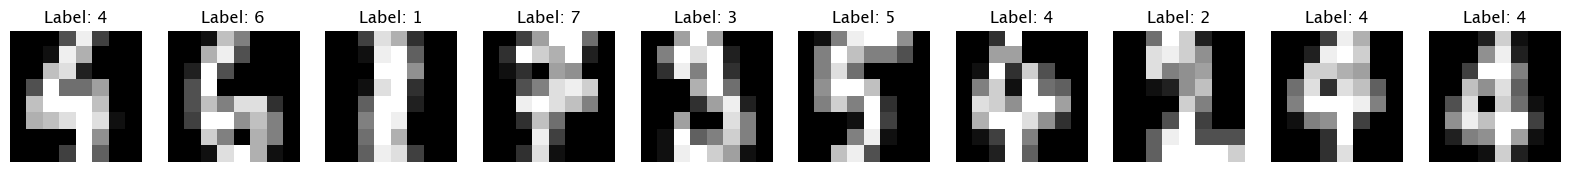

In [41]:
def plot_samples(samples: list[np.ndarray], labels: list[np.ndarray]) -> None:
    """
    Plot the samples in a grid.
    
    Parameters:
    - samples (list[np.ndarray]): The samples to plot
    - labels (list[np.ndarray]): The labels of the samples
    """
    
    # Create a list to store the reshaped samples
    reshaped_samples = []
    
    # Iterate over the samples
    for sample in samples:
        # Compute the new shape
        new_shape = np.sqrt(sample.shape).astype(int)[0]
        
        # Reshape the sample
        sample = sample.reshape(new_shape, new_shape)
        
        # Append the reshaped sample
        reshaped_samples.append(sample)
        
    # Plot the samples in a grid
    _, axes = plt.subplots(1, len(samples), figsize=(20, 5))
    for i, ax in enumerate(axes):
        ax.imshow(reshaped_samples[i], cmap='gray')
        ax.set_title(f'Label: {labels[i]}')
        ax.axis('off')
        
        
# Plot the first 10 samples
plot_samples(list(X_train.numpy()[:10]), list(y_train.numpy()[:10]))

### Building the model

In [42]:

model = Sequential(
    nn.Linear(in_features=X_train.shape[1], out_features=24),
    nn.ReLU(),
    nn.Dropout(p=0.1),
    nn.Linear(in_features=24, out_features=32),
    nn.ReLU(),
    nn.Dropout(p=0.1),
    nn.Linear(in_features=32, out_features=12),
    nn.Tanh(),
    nn.Dropout(p=0.1),
    nn.Linear(in_features=12, out_features=num_classes),
    nn.Softmax(dim=1)
)

# Initialize the optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

# Initialize the loss function
loss_fn = nn.CrossEntropyLoss()

### Initializing the model

In [43]:
# Display the model summary
model

Sequential(
  (0): Linear(in_features=64, out_features=24, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.1, inplace=False)
  (3): Linear(in_features=24, out_features=32, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.1, inplace=False)
  (6): Linear(in_features=32, out_features=12, bias=True)
  (7): Tanh()
  (8): Dropout(p=0.1, inplace=False)
  (9): Linear(in_features=12, out_features=10, bias=True)
  (10): Softmax(dim=1)
)

### Training the model

In [44]:
history = model.fit(
    X_train = X_train, 
    y_train = y_train,
    optimizer = optimizer,
    loss_fn = loss_fn,
    X_valid = X_valid,
    y_valid = y_valid,
    batch_size = batch_size,
    epochs = epochs,
    metrics = [metrics.accuracy],
    callbacks = [callbacks.EarlyStopping(monitor='val_loss', patience=10)]
)

Epoch 1/500 --> loss: 2.3028 - accuracy: 0.0939 | Validation loss: 2.3021 - Validation accuracy: 0.1146                     
Epoch 2/500 --> loss: 2.3021 - accuracy: 0.1167 | Validation loss: 2.3015 - Validation accuracy: 0.1007                     
Epoch 3/500 --> loss: 2.2998 - accuracy: 0.1688 | Validation loss: 2.2971 - Validation accuracy: 0.2083                     
Epoch 4/500 --> loss: 2.2827 - accuracy: 0.2396 | Validation loss: 2.2615 - Validation accuracy: 0.1979                     
Epoch 5/500 --> loss: 2.2297 - accuracy: 0.2159 | Validation loss: 2.2189 - Validation accuracy: 0.1840                     
Epoch 6/500 --> loss: 2.1998 - accuracy: 0.2259 | Validation loss: 2.2006 - Validation accuracy: 0.2326                     
Epoch 7/500 --> loss: 2.1807 - accuracy: 0.2746 | Validation loss: 2.1792 - Validation accuracy: 0.3125                     
Epoch 8/500 --> loss: 2.1548 - accuracy: 0.3504 | Validation loss: 2.1268 - Validation accuracy: 0.4549                     


In [45]:
# Save the model
torch.save(model.state_dict(), model_path)

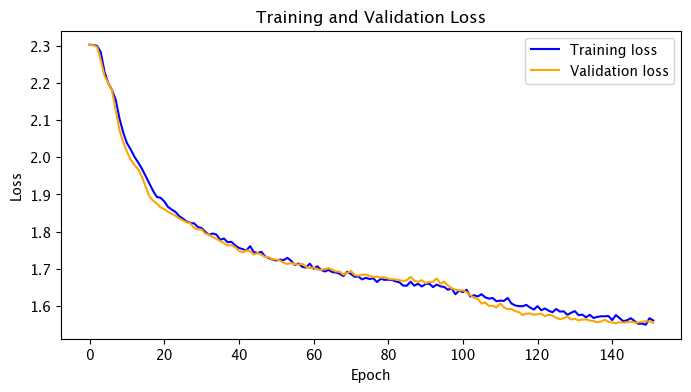

In [46]:
# Plot the training and validation loss
data_analysis.plot_history(history["loss"].numpy(), history["val_loss"].numpy(), "Training and Validation Loss", "Epoch", "Loss")

### Evaluation

In [47]:
# Disable gradient computation
with torch.no_grad():
    # Set the model in evaluation mode
    model.eval()
    
    # Compute the predictions
    predictions = model(X_test)

# Apply the argmax function to the predictions
predictions = torch.argmax(predictions.detach(), dim=1)

Accuracy: 0.94


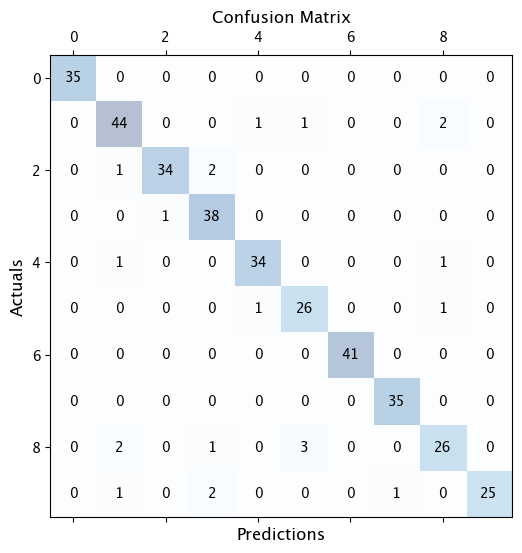

In [48]:
# Compute the accuracy
accuracy = metrics.accuracy(y_test, predictions)
confusion_matrix = metrics.confusion_matrix(num_classes, y_test, predictions)

# Print the accuracy
print(f"Accuracy: {accuracy.item():.2f}")

# Plot the confusion matrix
data_analysis.plot_confusion_matrix(confusion_matrix.numpy())